## Audio Classification

### 1. Import and Install Dependencies

#### 1.1 Install Dependencies

In [1]:
!pip install opendatasets --upgrade

In [2]:
import opendatasets as od
import os
dataset_url = 'https://www.kaggle.com/kenjee/z-by-hp-unlocked-challenge-3-signal-processing'
od.download(dataset_url)
os.rename('z-by-hp-unlocked-challenge-3-signal-processing','data')

100%|██████████| 604M/604M [02:42<00:00, 3.90MB/s] 


#### 1.2 Load Dependencies

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd

2024-01-26 01:38:34.488509: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 01:38:34.529723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 01:38:34.529763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 01:38:34.531018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 01:38:34.537371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 01:38:34.538056: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-01-26 01:38:35.281723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2. Build Data Loading Function

#### 2.1. Define Paths to Files

In [4]:
CAPUCHIN_FILE = os.path.join('data','Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NON_CAPUCHIN_FILE = os.path.join('data','Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

#### 2.2. Build Dataloading Function

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)

    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)

    # Remove training axis
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Goes from 44100Hz to 16000Hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav


#### 2.3. Plot Wave

In [6]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NON_CAPUCHIN_FILE)

2024-01-26 01:38:36.013791: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


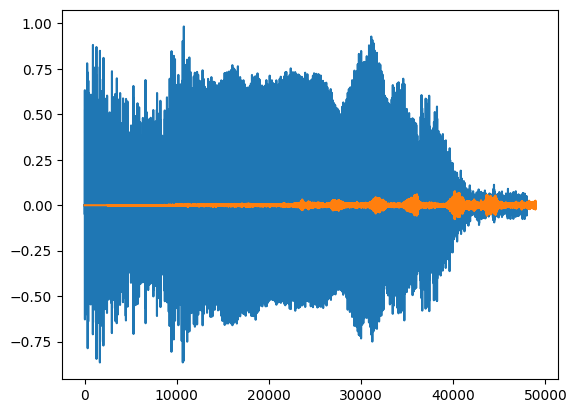

In [7]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create Tensorflow Dataset

#### 3.1. Define Paths to Positive and Negative Data

In [8]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data','Parsed_Not_Capuchinbird_Clips')

#### 3.2. Create Tensorflow Datasets

In [9]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

#### 3.3. Add labels and Combine Positive and Negative Samples

In [10]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

### 4. Determine Average Length of a Capuchin Call

#### 4.1 Calculate Wave Cycle Length

In [11]:
lengths = []

for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

#### 4.2 Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### 5. Build Preprocessing Function to Convert to Spectrogram

#### 5.1 Build Preprocessing Function

In [15]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    return spectrogram, label

#### 5.2 Test Out the Function and Viz the Spectrogram

In [16]:
filepath, label = positives.shuffle(1000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

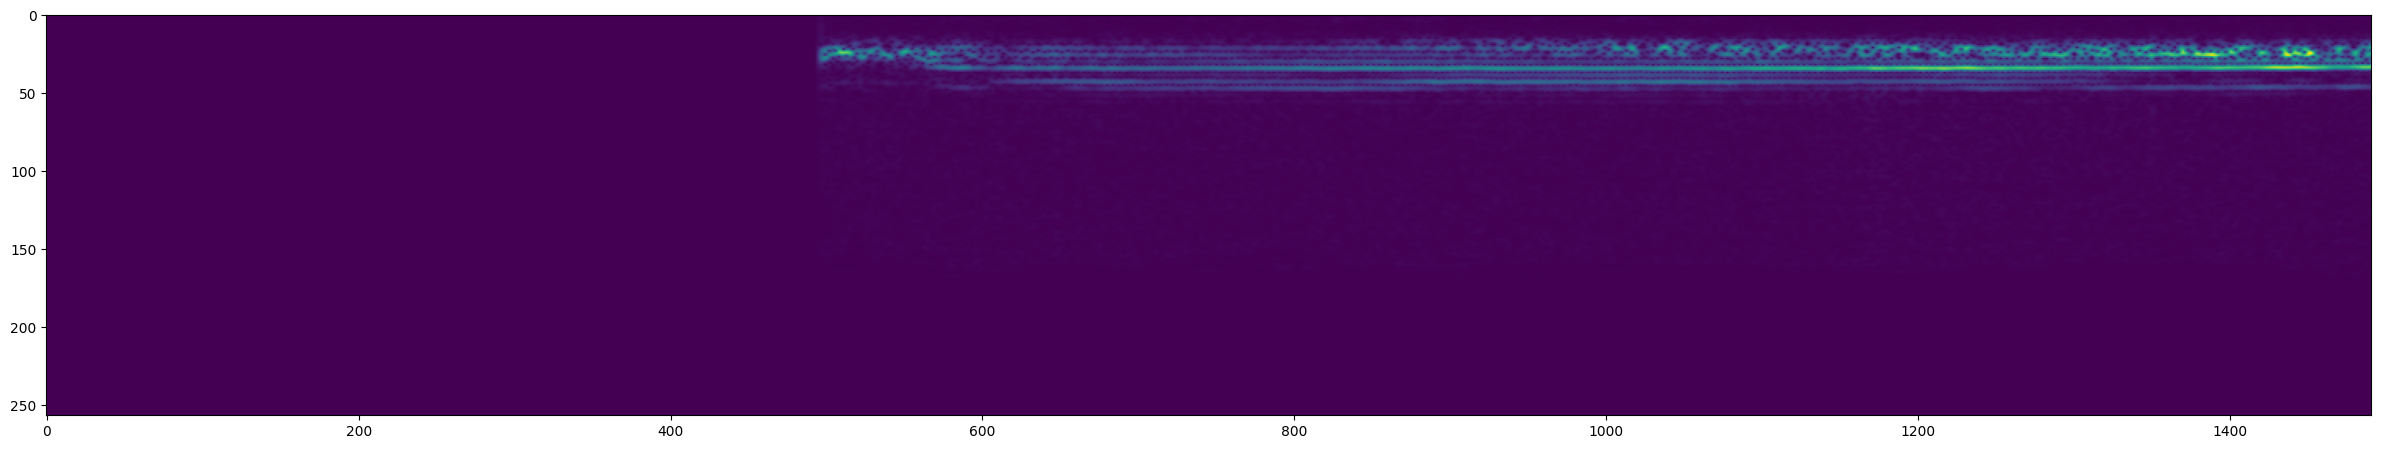

In [17]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### 6. Create Training and Testing Partitions

#### 6.1 Create a Tensorflow Data Pipeline

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

#### 6.2 Split into Training and Testing Partitions

In [19]:
train = data.take(36)
test = data.skip(36).take(15)

#### 6.3 Test One Batch

In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 1491, 257, 1)

In [22]:
labels

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

### 7. Build Deep Learning Model

#### 7.1 Load Tensorflow Dependencies

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten

#### 7.2 Build Sequential Model, Compile and View Summary

In [24]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPool2D())
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2024-01-26 01:38:52.982380: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 759808000 exceeds 10% of free system memory.
2024-01-26 01:38:53.099995: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 759808000 exceeds 10% of free system memory.
2024-01-26 01:38:53.205002: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 759808000 exceeds 10% of free system memory.


In [25]:
model.compile(optimizer='adam', loss='BinaryCrossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

#### 7.3 Fit Model, View Loss and KPI Plots

In [26]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2024-01-26 01:38:53.565910: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 759808000 exceeds 10% of free system memory.
2024-01-26 01:38:53.661156: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 759808000 exceeds 10% of free system memory.
2024-01-26 01:38:54.191563: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 196192256 bytes after encountering the first element of size 24524032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


20/36 [===============>..............] - ETA: 45s - loss: 0.9713 - recall: 0.8409 - precision: 0.8706

36/36 [==============================] - 115s 3s/step - loss: 0.5682 - recall: 0.8963 - precision: 0.9245 - val_loss: 0.0175 - val_recall: 1.0000 - val_precision: 0.9846
Epoch 2/4
36/36 [==============================] - 124s 3s/step - loss: 0.0851 - recall: 0.9742 - precision: 0.9869 - val_loss: 5.3561e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 123s 3s/step - loss: 0.0114 - recall: 0.9873 - precision: 0.9936 - val_loss: 0.0093 - val_recall: 0.9863 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 131s 4s/step - loss: 0.0040 - recall: 0.9937 - precision: 1.0000 - val_loss: 0.0013 - val_recall: 1.0000 - val_precision: 1.0000


In [27]:
hist.history

{'loss': [0.568152129650116,
  0.08505865931510925,
  0.011386910453438759,
  0.003963876981288195],
 'recall': [0.8963414430618286,
  0.9741935729980469,
  0.9873417615890503,
  0.9937499761581421],
 'precision': [0.9245283007621765, 0.9869281053543091, 0.993630588054657, 1.0],
 'val_loss': [0.017472216859459877,
  0.0005356143810786307,
  0.00933604035526514,
  0.0013194804778322577],
 'val_recall': [1.0, 1.0, 0.9863013625144958, 1.0],
 'val_precision': [0.9846153855323792, 1.0, 1.0, 1.0]}

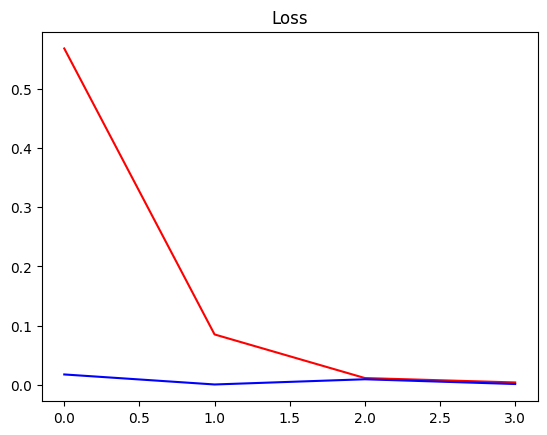

In [28]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

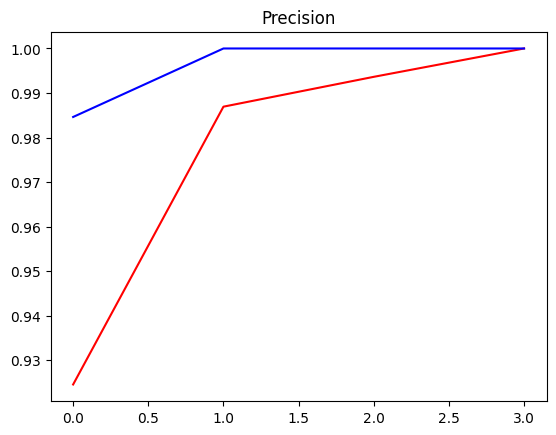

In [29]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

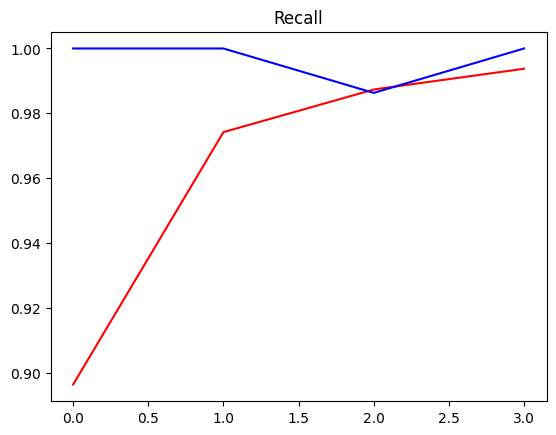

In [30]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

### 8. Make a Prediction on a Single Clip

#### 8.1 Get One Batch and Make a Prediction

In [31]:
X_test, y_test = test.as_numpy_iterator().next()

In [32]:
y_pred = model.predict(X_test)
y_pred

1/1 [==============================] - 0s 423ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [5.2846952e-13],
       [3.1820153e-26],
       [7.5706733e-12],
       [1.0000000e+00],
       [7.4471640e-34],
       [1.0064141e-11],
       [1.0000000e+00],
       [9.9999970e-01],
       [1.4164094e-12],
       [1.0000000e+00],
       [1.2637149e-09],
       [3.2651601e-09],
       [9.9996012e-01],
       [0.0000000e+00]], dtype=float32)

In [33]:
y_test

array([1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [34]:
y_test.astype(int)

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0])

#### 8.2. Convert Logits to Classes

In [35]:
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
y_pred

[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

### 9. Build Forest Parsing Functions

#### 9.1. Load up MP3s

In [36]:
def load_mp3_16k_mono(filename):
  res = tfio.audio.AudioIOTensor(filename)

  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1)/2

  # Extract sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  # Resample to 16 kHz
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
  return wav


In [37]:
mp3_file = os.path.join('data','Forest Recordings', 'recording_00.mp3')

In [38]:
wav_file = load_mp3_16k_mono(mp3_file)

In [39]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav_file, wav_file, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [40]:
len(audio_slices)

60

In [41]:
samples, index = audio_slices.as_numpy_iterator().next()

In [42]:
samples[0]

array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
        6.2619494e-03, -1.5455363e-02, -8.7941047e-03], dtype=float32)

In [43]:
samples.shape

(1, 48000)

#### 9.2. Build Function to Convert Clips into Windowed Spectrograms

In [44]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram

#### 9.3. Convert Longer Clips into Windows and Make Predictions

In [45]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav_file, wav_file, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(60)

In [46]:
len(audio_slices)

1

In [47]:
y_pred = model.predict(audio_slices)
y_pred = [1 if pred > 0.90 else 0 for pred in y_pred]
len(y_pred)

1/1 [==============================] - 1s 1s/step


60

#### 9.4. Group Consecutive Detections

In [48]:
from itertools import groupby

y_pred = [key for key, group in groupby(y_pred)]
y_pred

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [49]:
total_call = np.sum(y_pred)
total_call

5

### 10. Make Predictions

#### 10.1. Loop over all recordings and make predictions

In [50]:
results = {}

for file_name in os.listdir(os.path.join('data', 'Forest Recordings')):
  mp3_file = os.path.join('data','Forest Recordings', file_name)
  wav_file = load_mp3_16k_mono(mp3_file)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav_file, wav_file, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(60)

  y_pred = model.predict(audio_slices)
  y_pred = [1 if pred > 0.90 else 0 for pred in y_pred]
  y_pred = [key for key, group in groupby(y_pred)]
  total_call = np.sum(y_pred)

  results[file_name] = total_call

1/1 [==============================] - 1s 1s/step


In [51]:
results

{'recording_11.mp3': 4,
 'recording_91.mp3': 0,
 'recording_20.mp3': 0,
 'recording_52.mp3': 0,
 'recording_37.mp3': 3,
 'recording_17.mp3': 6,
 'recording_10.mp3': 5,
 'recording_74.mp3': 0,
 'recording_40.mp3': 1,
 'recording_99.mp3': 5,
 'recording_81.mp3': 4,
 'recording_02.mp3': 0,
 'recording_70.mp3': 1,
 'recording_86.mp3': 3,
 'recording_63.mp3': 4,
 'recording_03.mp3': 0,
 'recording_89.mp3': 2,
 'recording_44.mp3': 1,
 'recording_65.mp3': 4,
 'recording_16.mp3': 6,
 'recording_56.mp3': 4,
 'recording_19.mp3': 0,
 'recording_47.mp3': 5,
 'recording_76.mp3': 0,
 'recording_88.mp3': 0,
 'recording_95.mp3': 5,
 'recording_49.mp3': 0,
 'recording_05.mp3': 0,
 'recording_78.mp3': 3,
 'recording_59.mp3': 7,
 'recording_90.mp3': 0,
 'recording_04.mp3': 5,
 'recording_28.mp3': 8,
 'recording_12.mp3': 0,
 'recording_48.mp3': 4,
 'recording_53.mp3': 0,
 'recording_36.mp3': 0,
 'recording_83.mp3': 0,
 'recording_60.mp3': 5,
 'recording_73.mp3': 0,
 'recording_75.mp3': 1,
 'recording_80.m

### 11. Export Results

In [64]:
results_df = pd.DataFrame(list(results.items()), columns=['recording', 'capuchin_calls'])
results_df.to_csv('resluts.csv', index=False)

In [63]:
results_df

,recording,capuchin_calls
0,recording_11.mp3,4
1,recording_91.mp3,0
2,recording_20.mp3,0
3,recording_52.mp3,0
4,recording_37.mp3,3
...,...,...
95,recording_64.mp3,3
96,recording_55.mp3,0
97,recording_68.mp3,1
98,recording_93.mp3,5
